<a href="https://colab.research.google.com/github/ZenanAH/Team_Energy/blob/master/RNN_on_groups_zen_with_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras .models import Sequential
from tensorflow.keras .layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras .optimizers import SGD
import math
from sklearn.metrics import mean_absolute_percentage_error
import joblib

In [24]:
#!pip install tensorflow
name="H"
tariff='Std'


In [37]:
def split_data(filename,tariff):
#     print('Input precise path for data including extension')
#     filename = input()
    fulldata = pd.read_csv(filename)
    fulldata['DateTime'] = pd.to_datetime(fulldata['DateTime'])
    
    if tariff=="ToU":
      start_date='2013-01-01'
    else: 
      start_date='2012-01-01'

    train_data = fulldata[(fulldata['DateTime'] >= start_date) & (fulldata['DateTime'] < '2014-01-01')].reset_index(drop = True)
    validation_data = fulldata[(fulldata['DateTime'] >= '2014-01-01') & (fulldata['DateTime'] < '2014-02-01')].reset_index(drop = True)
    test_data = fulldata[(fulldata['DateTime'] >= '2014-01-01') & (fulldata['DateTime'] < '2014-03-01')].reset_index(drop = True)
    return train_data, validation_data, test_data

def create_data(acorn_group,tariff):
    tdata, vdata, testd=split_data(f'https://storage.googleapis.com/energy_usage_prediction_903/df_{name}_avg_{tariff}_v1.csv',tariff)
    # add val and train for prophet
    combine_tr_vl=False
    
    if combine_tr_vl==True:
      pdata=pd.concat([tdata,vdata],axis=0).reset_index(drop=True)
    else:
      pdata=tdata

    global_average=False

    if global_average==False:
        # not for global average
        tdata.drop(columns='Unnamed: 0',inplace=True)
        testd.drop(columns='Unnamed: 0',inplace=True)
        vdata.drop(columns='Unnamed: 0',inplace=True)
        
    # group by
    df5=pdata.loc[:,['DateTime','KWH/hh']]
    df5.set_index('DateTime',inplace=True)

    train_df=df5.groupby(by=df5.index).mean()
    train_df=train_df.reset_index()

    test_df=testd.loc[:,['DateTime','KWH/hh']].groupby(by=testd['DateTime']).mean()
    test_df.reset_index(inplace=True)

    val_df=vdata.loc[:,['DateTime','KWH/hh']].groupby(by=vdata['DateTime']).mean()
    val_df.reset_index(inplace=True)
    
    return train_df,test_df,val_df

def get_weather(train_df, test_df,val_df,tariff):
    twd, vwd, testwd=split_data('https://storage.googleapis.com/weather-data-processed-for-le-wagon/cleaned_weather_hourly_darksky.csv',tariff)
  
    combine_tr_vl=False
    
    if combine_tr_vl==True:
      wd=pd.concat([twd,vwd],axis=0).reset_index(drop=True)
    else:
      wd=twd

    
    wd_filt=wd[['DateTime','temperature','windSpeed','precipType_rain']].dropna()
    wd_filt['DateTime']=pd.to_datetime(wd_filt['DateTime'])
    wd_filt[wd_filt.columns[1:].to_list()]=wd_filt[wd_filt.columns[1:].to_list()].interpolate(method='linear')
    
    test_wd=testwd[['DateTime','temperature','windSpeed','precipType_rain']].dropna()
    test_wd['DateTime']=pd.to_datetime(test_wd['DateTime'])
    
    val_wd=vwd[['DateTime','temperature','windSpeed','precipType_rain']].dropna()
    val_wd['DateTime']=pd.to_datetime(val_wd['DateTime'])
    # # wind = wd_filt['windSpeed'].interpolate(method='linear')
    # # rain = wd_filt['precipType_rain'].interpolate(method='linear')  
    train_wd=train_df[['DateTime']].merge(wd_filt,on='DateTime',how='inner')
    test_wd=test_df[['DateTime']].merge(test_wd,on='DateTime',how='inner')
    val_wd=val_df[['DateTime']].merge(val_wd,on='DateTime',how='inner')

    train_wd[train_wd.columns[1:].to_list()]=train_wd[train_wd.columns[1:].to_list()].interpolate(method='linear')
    test_wd[test_wd.columns[1:].to_list()]=test_wd[test_wd.columns[1:].to_list()].interpolate(method='linear')
    val_wd[val_wd.columns[1:].to_list()]=val_wd[test_wd.columns[1:].to_list()].interpolate(method='linear')

    return train_wd, test_wd,val_wd

def plot_predictions(df_plot):
    plt.figure(figsize=(18,6))
    sns.lineplot(x=df_plot['DateTime'],y=df_plot['Predicted'],label='Forecast')
    sns.lineplot(x=df_plot['DateTime'],y=df_plot['y'],label='Actua')
    plt.title('Electricity Consumption Prediction')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh/hh)')
    plt.legend()
    plt.show()

def return_mape(test,predicted):
    mape = mean_absolute_percentage_error(test, predicted)
    print("The  mean absolute percenatge error is {}.".format(mape))

In [52]:
train_df,test_df,val_df=create_data(name,tariff)
train_wd, test_wd,val_wd=get_weather(train_df, test_df,val_df,tariff)
train=train_wd.merge(train_df, on='DateTime')
test=test_wd.merge(test_df, on='DateTime')
val=val_wd.merge(val_df, on='DateTime')


In [53]:
def prepare_sequences(train_df,test_df,val_df):
  train_df.set_index('DateTime',inplace=True)
  test_df.set_index('DateTime',inplace=True)
  val_df.set_index('DateTime',inplace=True)
  training_set = train_df.loc[:,:].values
  test_set = test_df.loc[:,:].values
  # Scaling the training set
  sc = MinMaxScaler(feature_range=(0,1))
  training_set_scaled = sc.fit_transform(training_set)
  #Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
  # So for each element of training set, we have 60 previous training set elements 
  X_train = []
  y_train = []
  for i in range(60,len(training_set_scaled)):
      X_train.append(training_set_scaled[i-60:i,0])
      y_train.append(training_set_scaled[i,0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  # Reshaping X_train for efficient modelling
  X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
  # Now to get the test set ready in a similar way as the training set.
  # The following has been done so first 60 entries of test set have 60 previous values which is impossible to get 
  dataset_total = pd.concat((train_df["KWH/hh"][:'2013'],test_df["KWH/hh"]['2014':]),axis=0)
  inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs  = sc.transform(inputs)
  # Preparing X_test and predicting the prices
  X_test = []
  for i in range(60,len(inputs)):
      X_test.append(inputs[i-60:i,0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

  return  X_train,y_train,X_test,sc,test_set

In [54]:
X_train,y_train,X_test,sc,test_set=prepare_sequences(train_df,test_df,val_df)

In [55]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='MeanAbsolutePercentageError')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1095/1095 [==============================] - 25s 14ms/step - loss: 1514.9718
Epoch 2/50
1095/1095 [==============================] - 15s 14ms/step - loss: 388.3299
Epoch 3/50
1095/1095 [==============================] - 15s 14ms/step - loss: 751.0836
Epoch 4/50
1095/1095 [==============================] - 15s 14ms/step - loss: 585.2172
Epoch 5/50
1095/1095 [==============================] - 16s 14ms/step - loss: 292.8751
Epoch 6/50
1095/1095 [==============================] - 15s 14ms/step - loss: 1400.1088
Epoch 7/50
1095/1095 [==============================] - 15s 14ms/step - loss: 494.7235
Epoch 8/50
1095/1095 [==============================] - 16s 14ms/step - loss: 194.4390
Epoch 9/50
1095/1095 [==============================] - 15s 14ms/step - loss: 28.6181
Epoch 10/50
1095/1095 [==============================] - 15s 14ms/step - loss: 539.7250
Epoch 11/50
1095/1095 [==============================] - 15s 14ms/step - loss: 521.4572
Epoch 12/50
1095/1095 [=================

In [56]:
#X_train,y_train,X_test,sc,test_set=prepare_sequences(train_df,test_df,val_df)
# prediction
predicted_consumption = regressor.predict(X_test)
predicted_consumption = sc.inverse_transform(predicted_consumption)

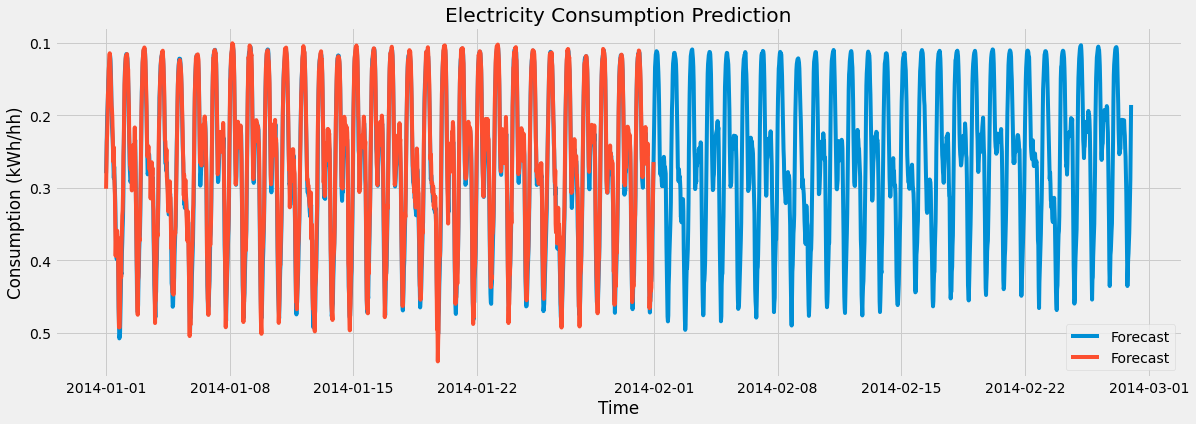

The  mean absolute percenatge error is 0.04788421014332351.


In [79]:

# Visualizing the results for LSTM
df_plot=test_df
df_plot=df_plot.merge(val_df,left_on=df_plot.index,right_on=val_df.index,how='outer').fillna('')
df_plot.drop(columns='KWH/hh_x',inplace=True)
df_plot.rename(columns={'key_0':'DateTime','KWH/hh_y':'y'},inplace=True)
df_plot['Predicted']=predicted_consumption
plot_predictions(df_plot)
# Evaluating our model
return_mape(test_set,predicted_consumption)

In [81]:
joblib.dump(regressor,f'model_{name}_{tariff}.joblib')

['model_H_Std.joblib']